## 스타벅스, 이디야 위치 분석하기

* 이디야는 스타벅스 근처에 입점한다는 설이 있습니다. 과연 이디야와 스타벅스의 매장입지는 얼마나 차이가 날까요? 

### 다루는 내용
* 공공데이터를 활용해 텍스트 데이터 정제하고 원하는 정보 찾아내기
* 문자열에서 원하는 텍스트 추출하기
* 문자열을 활용한 다양한 분석 방법과 위치 정보 사용하기
* folium을 통한 위경도 데이터 시각화

### 필요한 데이터 셋
* https://www.data.go.kr/dataset/15012005/fileData.do

In [2]:
# 데이터 분석을 위해 pandas를, 수치계산을 위해 numpy를, 시각화를 위해 seaborn을 불러옵니다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc



In [3]:
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [5]:
# 음수 마이너스 표시가 깨질 때
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus']=False

<AxesSubplot:title={'center':'한글'}>

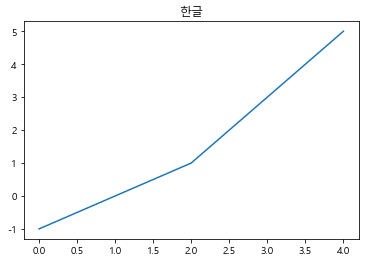

In [7]:
# 한글폰트와 마이너스 폰트 설정 확인
pd.Series([-1, 0, 1, 3, 5]).plot(title="한글")

In [8]:
# 파일을 불러와 df 라는 변수에 담습니다.
# shape 를 통해 불러온 csv 파일의 크기를 확인합니다.
df = pd.read_csv('./data/shopinfo.csv', sep='|', encoding='utf-8')
df.shape

(573680, 39)

In [9]:
df.head()

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,...,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
0,19905471,와라와라호프,NaN,Q,음식,Q09,유흥주점,Q09A01,호프/맥주,I56219,...,1168010600106040000014378,대치상가,서울특별시 강남구 남부순환로 2933,135280,6280.0,NaN,1,NaN,127.061026,37.493922
1,19911397,커피빈코리아선릉로93길점,코리아선릉로93길점,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,...,1168010100106960042022041,NaN,서울특별시 강남구 선릉로93길 6,135080,6149.0,NaN,1,NaN,127.047883,37.505675
2,19911801,프로포즈,NaN,Q,음식,Q09,유흥주점,Q09A01,호프/맥주,I56219,...,1154510200101620001017748,NaN,서울특별시 금천구 가산로 34-6,153010,8545.0,NaN,1,NaN,126.899220,37.471711
3,19912201,싱싱커피&토스트,NaN,Q,음식,Q07,패스트푸드,Q07A10,토스트전문,I56192,...,2653010400105780000002037,산업용품유통상가,부산광역시 사상구 괘감로 37,617726,46977.0,NaN,1,26,128.980455,35.159774
4,19932756,가락사우나내스낵,NaN,F,생활서비스,F09,대중목욕탕/휴게,F09A02,사우나/증기탕/온천,S96121,...,1171010500102560005010490,NaN,서울특별시 송파구 가락로 71,138846,5690.0,NaN,1,NaN,127.104071,37.500249


In [10]:
# 정보보기
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573680 entries, 0 to 573679
Data columns (total 39 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   상가업소번호     573680 non-null  int64  
 1   상호명        573679 non-null  object 
 2   지점명        76674 non-null   object 
 3   상권업종대분류코드  573680 non-null  object 
 4   상권업종대분류명   573680 non-null  object 
 5   상권업종중분류코드  573680 non-null  object 
 6   상권업종중분류명   573680 non-null  object 
 7   상권업종소분류코드  573680 non-null  object 
 8   상권업종소분류명   573680 non-null  object 
 9   표준산업분류코드   539290 non-null  object 
 10  표준산업분류명    539290 non-null  object 
 11  시도코드       573680 non-null  int64  
 12  시도명        573680 non-null  object 
 13  시군구코드      573680 non-null  int64  
 14  시군구명       573680 non-null  object 
 15  행정동코드      573680 non-null  int64  
 16  행정동명       573680 non-null  object 
 17  법정동코드      573680 non-null  int64  
 18  법정동명       573680 non-null  object 
 19  지번코드       573680 non-n

<AxesSubplot:>

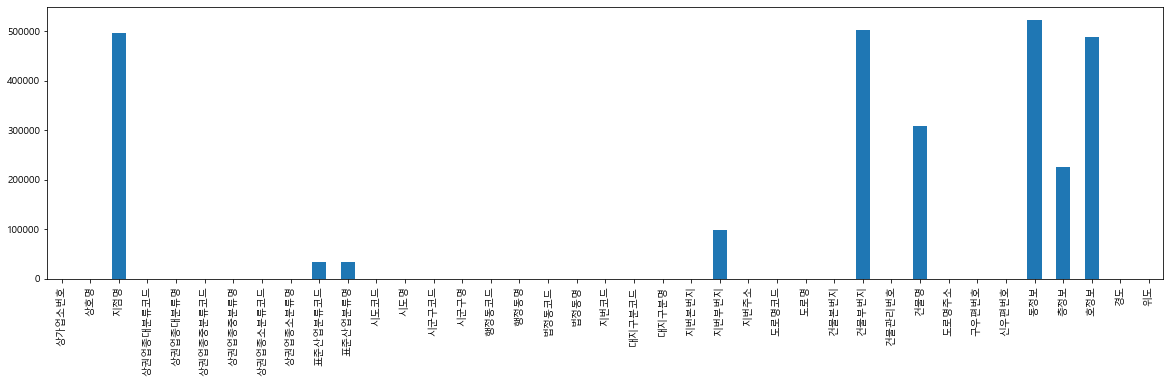

In [14]:
# 결측치 보기
df.isnull().sum().plot.bar(figsize=(20,5))

In [15]:
# 사용할 컬럼만 따로 모음
columns = ['상호명', '상권업종대분류명', '상권업종중분류명', '상권업종소분류명', 
           '시도명', '시군구명', '행정동명', '법정동명', '도로명주소', 
           '경도', '위도']

df = df[columns].copy()
df.shape

(573680, 11)

In [16]:
# 제거 후 메모리 사용량 보기
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573680 entries, 0 to 573679
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   상호명       573679 non-null  object 
 1   상권업종대분류명  573680 non-null  object 
 2   상권업종중분류명  573680 non-null  object 
 3   상권업종소분류명  573680 non-null  object 
 4   시도명       573680 non-null  object 
 5   시군구명      573680 non-null  object 
 6   행정동명      573680 non-null  object 
 7   법정동명      573680 non-null  object 
 8   도로명주소     573680 non-null  object 
 9   경도        573680 non-null  float64
 10  위도        573680 non-null  float64
dtypes: float64(2), object(9)
memory usage: 48.1+ MB


In [17]:
# 서울만 따로 추출
df_seoul = df[df['시도명'] == '서울특별시'].copy()
df_seoul.shape

(407376, 11)

In [18]:
df_seoul.head()

,상호명,상권업종대분류명,상권업종중분류명,상권업종소분류명,시도명,시군구명,행정동명,법정동명,도로명주소,경도,위도
0,와라와라호프,음식,유흥주점,호프/맥주,서울특별시,강남구,대치1동,대치동,서울특별시 강남구 남부순환로 2933,127.061026,37.493922
1,커피빈코리아선릉로93길점,음식,커피점/카페,커피전문점/카페/다방,서울특별시,강남구,역삼1동,역삼동,서울특별시 강남구 선릉로93길 6,127.047883,37.505675
2,프로포즈,음식,유흥주점,호프/맥주,서울특별시,금천구,독산3동,독산동,서울특별시 금천구 가산로 34-6,126.899220,37.471711
4,가락사우나내스낵,생활서비스,대중목욕탕/휴게,사우나/증기탕/온천,서울특별시,송파구,석촌동,석촌동,서울특별시 송파구 가락로 71,127.104071,37.500249
5,초밥왕,음식,일식/수산물,음식점-초밥전문,서울특별시,송파구,잠실6동,신천동,서울특별시 송파구 올림픽로 293-19,127.102490,37.515149


In [19]:
# "상호명_소문자" 컬럼을 만듭니다.
df_seoul['상호명_소문자'] = df_seoul['상호명'].str.lower()

In [20]:
df_seoul.loc[df_seoul['상호명_소문자'].str.contains('이디야|이디아|ediya'), '상호명_소문자'].shape

(543,)

In [21]:
df_seoul.loc[df_seoul['상호명_소문자'].str.contains('스타벅스|starbucks'), '상호명_소문자'].shape

(506,)

In [22]:
df_cafe = df_seoul[
    df_seoul['상호명_소문자'].str.contains('스타벅스|starbucks|이디야|이디아|ediya')].copy()
df_cafe.shape

(1049, 12)

In [23]:
# ~은 not을 의미. 스타벅스가 아닌 데이터는 이디야로 넣어주어도 되지만 아래 코드처럼 결측치를 이디야로 채우는 코드

df_cafe.loc[df_cafe['상호명_소문자'].str.contains('스타벅스|starbucks'), '브랜드명'] = '스타벅스'
df_cafe.loc[~df_cafe['상호명_소문자'].str.contains('스타벅스|starbucks'), '브랜드명'] = '이디야'
df_cafe[['상호명_소문자', '브랜드명']].head()

,상호명_소문자,브랜드명
1104,스타벅스,스타벅스
1675,이디야커피,이디야
2023,스타벅스종로3가점,스타벅스
2770,스타벅스,스타벅스
2957,이디야커피,이디야


In [24]:
df_cafe['브랜드명'].isnull().sum()

0

In [25]:
df_cafe[['상호명', '브랜드명']].tail()

,상호명,브랜드명
567090,스타벅스,스타벅스
567828,스타벅스,스타벅스
568636,이디야커피,이디야
570096,스타벅스,스타벅스
571052,스타벅스,스타벅스


In [27]:
df_cafe['상권업종중분류명'].value_counts()
# df_cafe['상권업종중분류명'].value_counts().plot.bar()

커피점/카페       1036
학원-어학           3
광고/인쇄           2
주유소/충전소         1
유흥주점            1
분양              1
주택수리            1
기타판매업           1
종합소매점           1
패스트푸드           1
운동/경기용품소매       1
Name: 상권업종중분류명, dtype: int64

In [28]:
df_cafe.to_csv('./data/shop_info_in_cafe.csv', encoding='utf-8')

In [29]:
df_cafe = df_cafe[df_cafe['상권업종중분류명'] == '커피점/카페'].copy()
df_cafe.shape

(1036, 13)

In [30]:
df_cafe['상권업종중분류명'].value_counts()

커피점/카페    1036
Name: 상권업종중분류명, dtype: int64

In [31]:
df_cafe['브랜드명'].value_counts()

이디야     532
스타벅스    504
Name: 브랜드명, dtype: int64

##### 여기까지가 전처리

<AxesSubplot:xlabel='브랜드명', ylabel='count'>

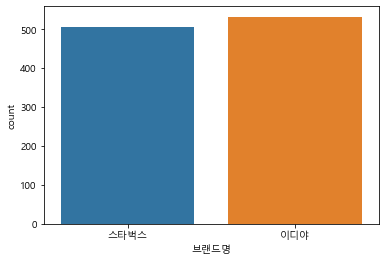

In [35]:
sns.countplot(data=df_cafe, x='브랜드명')

<AxesSubplot:xlabel='시군구명', ylabel='count'>

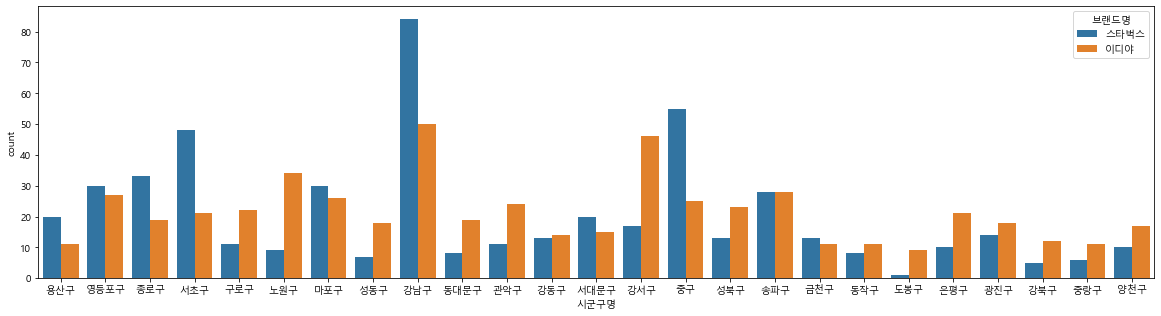

In [37]:
plt.figure(figsize=(20, 5))
sns.countplot(data=df_cafe, x='시군구명', hue='브랜드명')

<AxesSubplot:xlabel='경도', ylabel='위도'>

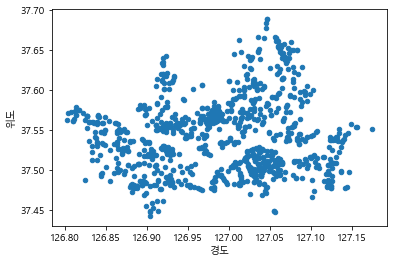

In [38]:
# pandas로 scatterplot을 그려봅니다.

df_cafe[['위도', '경도']].plot.scatter(x='경도', y='위도')

<AxesSubplot:xlabel='경도', ylabel='위도'>

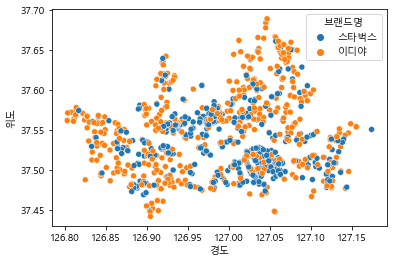

In [39]:
sns.scatterplot(data=df_cafe, x='경도', y='위도', hue='브랜드명')

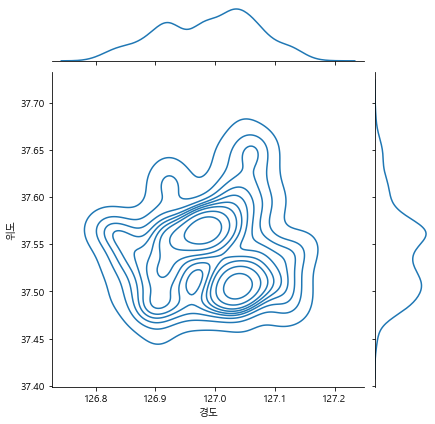

In [40]:
# jointplot 그리기
sns.jointplot(data=df_cafe, x='경도', y='위도', kind='kde')

In [41]:
# 구별로 그룹화 해서 점포 수 구하기

df_cafe_vs = df_cafe.groupby(['시군구명', '브랜드명'])['상호명'].count()
df_cafe_vs.head()

시군구명  브랜드명
강남구   스타벅스    84
      이디야     50
강동구   스타벅스    13
      이디야     14
강북구   스타벅스     5
Name: 상호명, dtype: int64

In [44]:
df_cafe_vs = df_cafe_vs.reset_index()
df_cafe_vs.tail()

,level_0,index,시군구명,브랜드명,상호명
45,45,45,종로구,이디야,19
46,46,46,중구,스타벅스,55
47,47,47,중구,이디야,25
48,48,48,중랑구,스타벅스,6
49,49,49,중랑구,이디야,11


In [45]:
df_cafe_vs = df_cafe_vs.rename(columns={'시군구명':'구','브랜드명':'브랜드명', '상호명':'매장수'})
df_cafe_vs.tail()

,level_0,index,구,브랜드명,매장수
45,45,45,종로구,이디야,19
46,46,46,중구,스타벅스,55
47,47,47,중구,이디야,25
48,48,48,중랑구,스타벅스,6
49,49,49,중랑구,이디야,11


<AxesSubplot:xlabel='구', ylabel='매장수'>

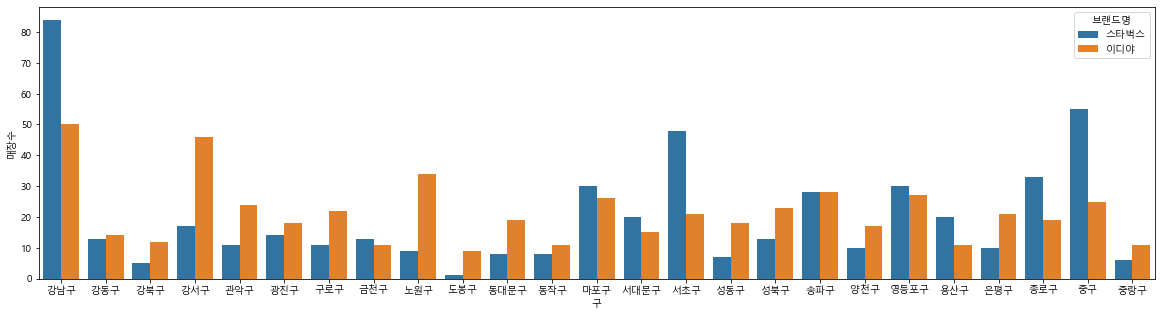

In [47]:
# seaborn의 barplot 을 활용해 구별 매장수를 시각화 합니다.
plt.figure(figsize=(20,5))
sns.barplot(data=df_cafe_vs, x='구', y='매장수', hue='브랜드명')

<AxesSubplot:xlabel='구', ylabel='매장수'>

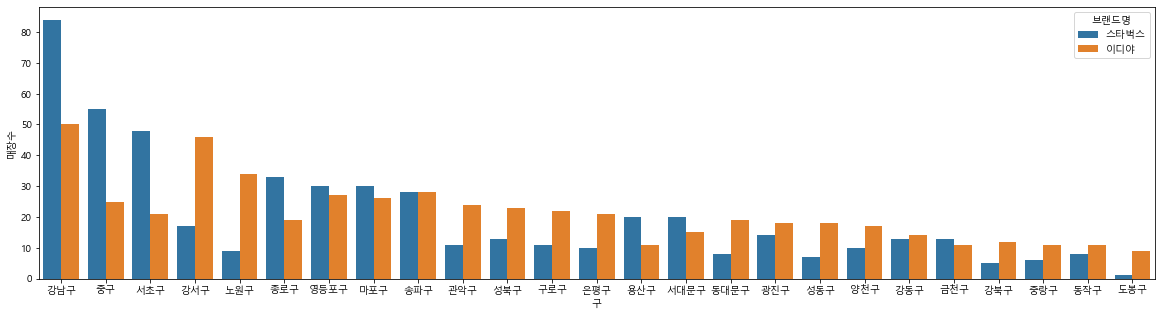

In [48]:
# seaborn의 barplot 을 활용해 구별 매장수를 시각화 합니다.
plt.figure(figsize=(20,5))
sns.barplot(data=df_cafe_vs.sort_values("매장수", ascending=False), x='구', y='매장수', hue='브랜드명')

#### 지도 시각화

In [49]:
import folium

In [50]:
lat = df_cafe['위도'].mean()
long = df_cafe['경도'].mean()
(lat,long)

(37.542921398212634, 126.9887885123524)

In [56]:
map = folium.Map(location=[lat, long], zoom_start=12, tiles='Stamen Toner')

for i in df_cafe.index:
    shop_lat = df_cafe.loc[i, '위도']
    shop_long = df_cafe.loc[i, '경도']
    title = f"{df_cafe.loc[i, '상호명']} - {df_cafe.loc[i, '도로명주소']}"

    color ='blue'
    if df_cafe.loc[i,'브랜드명'] == '이디야': color = 'orange'
    folium.CircleMarker(location=[shop_lat, shop_long], radius=3, color=color, tooltip=title).add_to(map)
map

In [57]:
geo_path = './data/seoul_municipalities_geo_simple.json'

import json
geo_json = json.load(open(geo_path, encoding='utf-8'))

In [59]:
geo_json['features'][0]['properties']['name']

'강동구'

In [60]:
df_star = df_cafe_vs[df_cafe_vs['브랜드명'] == '스타벅스'].copy()
df_star.head()

,level_0,index,구,브랜드명,매장수
0,0,0,강남구,스타벅스,84
2,2,2,강동구,스타벅스,13
4,4,4,강북구,스타벅스,5
6,6,6,강서구,스타벅스,17
8,8,8,관악구,스타벅스,11


In [61]:
# choropleth의 색상은 fill_color = 'YlGn'을 사용

m = folium.Map([lat, long])

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=df_star,
    columns=['구', '매장수'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='스타벅스 매장수'
).add_to(m)

m

In [62]:
df_ediya = df_cafe_vs[df_cafe_vs['브랜드명'] == '이디야'].copy()
df_ediya.head()

,level_0,index,구,브랜드명,매장수
1,1,1,강남구,이디야,50
3,3,3,강동구,이디야,14
5,5,5,강북구,이디야,12
7,7,7,강서구,이디야,46
9,9,9,관악구,이디야,24


In [63]:
m = folium.Map([lat, long], tiles='stamen toner')

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=df_ediya,
    columns=['구', '매장수'],
    key_on='feature.properties.name',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='이디야 매장수'
).add_to(m)


for i in df_cafe.index:
    sub_lat = df_cafe.loc[i, '위도']
    sub_long = df_cafe.loc[i, '경도']
    
    title = f"{df_cafe.loc[i, '상호명']} - {df_cafe.loc[i, '도로명주소']}"
    
    color = 'green'
    if df_cafe.loc[i, '브랜드명'] == '이디야':
        color = 'blue'
    
    folium.CircleMarker([sub_lat, sub_long],
                        radius=3,
                        color=color,
                          tooltip=title).add_to(m)

m